# Prequential RoBERTa DPR Pool

Within the paper [WatClaimCheck: A new Dataset for Claim Entailment and Inference](https://aclanthology.org/2022.acl-long.92.pdf), they state that the Dense Passage Retrieval model using a pooling.

## Prequential

The prequential dataset are partitions of 6 months such that it simulates how new topics are treated given new information. (See Section 5.2.1 of the paper)

## How do they pool?
1. For each claim, all of the sentences are pooled from every associated premise article and ranked using a similarity score.
2. Evidence sentences are concatenated in the descending order of similarity score.
3. The claim text and evidence sentences are concatenated.
4. Resulting text is truncated to maximum sequence length of transformer model to perform claim veracity inference

In [15]:
from helper import download_prequential_dataset
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification, BertTokenizer, TFBertModel
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [16]:
# Set Global Variables
DATASET_FP = "./WatClaimCheck_dataset" # CHANGE TO MATCH LOCAL
max_seq_len = 64

In [17]:
# Retrieve dataset
train_partitions, valid_partitions, test_partitions = download_prequential_dataset(DATASET_FP)
kfolds = len(train_partitions)

Extracting fields from metadata
Extracting fields from label
Extracting fields from metadata
Extracting fields from label
Extracting fields from metadata
Extracting fields from label
Start date is 2010-01-01. End date is 2021-07-01
Created 23 partitions


In [26]:
def create_multiclass_roberta_model(
    base_model_name='bert-base-cased', 
    num_classes=3,
    hidden_size = 100,
    dropout=0.3,
    learning_rate=0.00001):

    if base_model_name=="roberta-base":
        base_model = TFRobertaForSequenceClassification.from_pretrained(base_model_name)
    else:
        base_model = TFBertModel.from_pretrained(base_model_name)

    base_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int64, name='input_ids_layer')
    # token_type_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                #    'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = base_model(bert_inputs)

    bert_avg = tf.math.reduce_mean(bert_out[0], axis=1, keepdims=True)

    hidden = tf.keras.layers.Dense(hidden_size, activation = 'relu', name = 'hidden_layer')(bert_avg)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'classification_layer')(hidden)

    # classification_model = tf.keras.Model(inputs = [input_ids, token_type_ids, attention_mask], outputs = [classification])
    classification_model = tf.keras.Model(inputs = [input_ids, attention_mask], outputs = [classification])

    classification_model.compile(
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate),
        # loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.F1Score(average='macro')
        ]
    )

    return classification_model


In [19]:
preq_roberta_model = create_multiclass_roberta_model(base_model_name="roberta-base")
preq_roberta_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 64)]                 0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 64)]                 0         []                            
 r)                                                                                               
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1246471   ['attention_mask_layer[0][0]',
 assification_4 (TFRobertaF  (loss=None, logits=(None,    70         'input_ids_layer[0][0]'

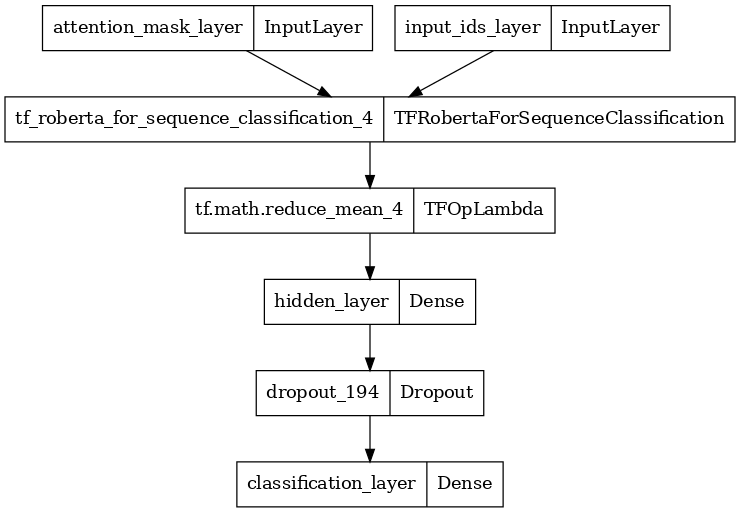

In [20]:
keras.utils.plot_model(preq_roberta_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [27]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

tscv_list = []

for i in range(kfolds, kfolds+1):

	print(f"Fold {i}")
	train_df = pd.concat(train_partitions[0:i+1])
	valid_df = pd.concat(valid_partitions[0:i+1])
	test_df = pd.concat(test_partitions[0:i+1])

	train_texts = list(train_df['claim'])
	valid_texts = list(valid_df['claim'])
	test_texts = list(test_df['claim'])

	train_encodings = tokenizer(train_texts, truncation=True, padding="max_length", max_length=max_seq_len, return_tensors='tf')
	valid_encodings = tokenizer(valid_texts, truncation=True, padding="max_length", max_length=max_seq_len, return_tensors='tf')
	# test_encodings = tokenizer(test_texts, truncation=True, padding="max_length", max_length=max_seq_len, return_tensors='tf')

	print(f"Train input id shape: {train_encodings.input_ids.shape}")
	print(f"Train attention mask shape: {train_encodings.attention_mask.shape}")
	print(f"Valid input id shape: {valid_encodings.input_ids.shape}")
	print(f"Valid attention mask shape: {valid_encodings.attention_mask.shape}")
	# print(f"Test input id shape: {test_encodings.input_ids.shape}")
	# print(f"Test attention mask shape: {test_encodings.attention_mask.shape}")

	print("Encoding labels")
	encoder = OneHotEncoder(sparse_output=False)
	train_labels = encoder.fit_transform(np.array(train_df['rating']).reshape(-1, 1))
	valid_labels = encoder.fit_transform(np.array(valid_df['rating']).reshape(-1, 1))
	# test_labels = list(test_df['rating'])
	
	preq_roberta_model = create_multiclass_roberta_model(base_model_name="roberta-base")

	preq_roberta_hist = preq_roberta_model.fit(
		x=[train_encodings.input_ids, train_encodings.attention_mask],
		y=tf.cast(train_labels, tf.float32),
		validation_data=(
			[valid_encodings.input_ids, valid_encodings.attention_mask],
			tf.cast(valid_labels, tf.float32)
		),
		batch_size=12,
		epochs=10
	)

	# print("Predicting on validation")
	# predictions = preq_roberta_model.predict([valid_encodings.input_ids, valid_encodings.attention_mask])
	# predictions_classes = tf.argmax(predictions, axis=-1)
	# kfold_f1_score = f1_score(np.array(valid_labels), predictions_classes.numpy(), average="macro")
	# print(f"F1 Score: {kfold_f1_score}")

	# tscv_list.append((preq_roberta_model, kfold_f1_score, preq_roberta_hist))

	print("\n\n")

Fold 23
Train input id shape: (26268, 64)
Train attention mask shape: (26268, 64)
Valid input id shape: (3266, 64)
Valid attention mask shape: (3266, 64)
Encoding labels


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/10
2189/2189 [==============================] - 521s 221ms/step - loss: 0.9395 - categorical_accuracy: 0.5644 - precision_4: 0.6469 - recall_4: 0.3406 - f1_score: 0.4098 - val_loss: 0.8796 - val_categorical_accuracy: 0.6032 - val_precision_4: 0.6757 - val_recall_4: 0.4415 - val_f1_score: 0.4221
Epoch 2/10
2189/2189 [==============================] - 469s 214ms/step - loss: 0.8744 - categorical_accuracy: 0.6139 - precision_4: 0.6734 - recall_4: 0.4607 - f1_score: 0.4341 - val_loss: 0.8555 - val_categorical_accuracy: 0.6127 - val_precision_4: 0.6548 - val_recall_4: 0.5168 - val_f1_score: 0.4302
Epoch 3/10
2189/2189 [==============================] - 485s 222ms/step - loss: 0.8402 - categorical_accuracy: 0.6322 - precision_4: 0.6908 - recall_4: 0.5054 - f1_score: 0.4454 - val_loss: 0.8425 - val_categorical_accuracy: 0.6212 - val_precision_4: 0.6589 - val_recall_4: 0.5447 - val_f1_score: 0.4375
Epoch 4/10
2189/2189 [==============================] - 493s 225ms/step - loss: 0.8125 -

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [39]:
preq_roberta_hist.history

{'loss': [0.9394639134407043,
  0.8744351267814636,
  0.8402213454246521,
  0.812538206577301,
  0.7899103760719299,
  0.7580568194389343,
  0.7299278974533081,
  0.6947646737098694,
  0.6615859866142273,
  0.6197308301925659],
 'categorical_accuracy': [0.5644129514694214,
  0.6139028668403625,
  0.6321760416030884,
  0.6456525325775146,
  0.6602329611778259,
  0.6791152954101562,
  0.6884041428565979,
  0.7030988335609436,
  0.7188594341278076,
  0.7341251969337463],
 'precision_4': [0.6468589901924133,
  0.6733807921409607,
  0.6907586455345154,
  0.7075052857398987,
  0.7239193320274353,
  0.74163419008255,
  0.7615616917610168,
  0.7849797606468201,
  0.8082185387611389,
  0.8315057158470154],
 'recall_4': [0.3406426012516022,
  0.46071264147758484,
  0.5053677558898926,
  0.5339957475662231,
  0.5521166324615479,
  0.5863788723945618,
  0.5955535173416138,
  0.6131795048713684,
  0.6364398002624512,
  0.6552839875221252],
 'f1_score': [0.40975716710090637,
  0.4340950548648834,
  

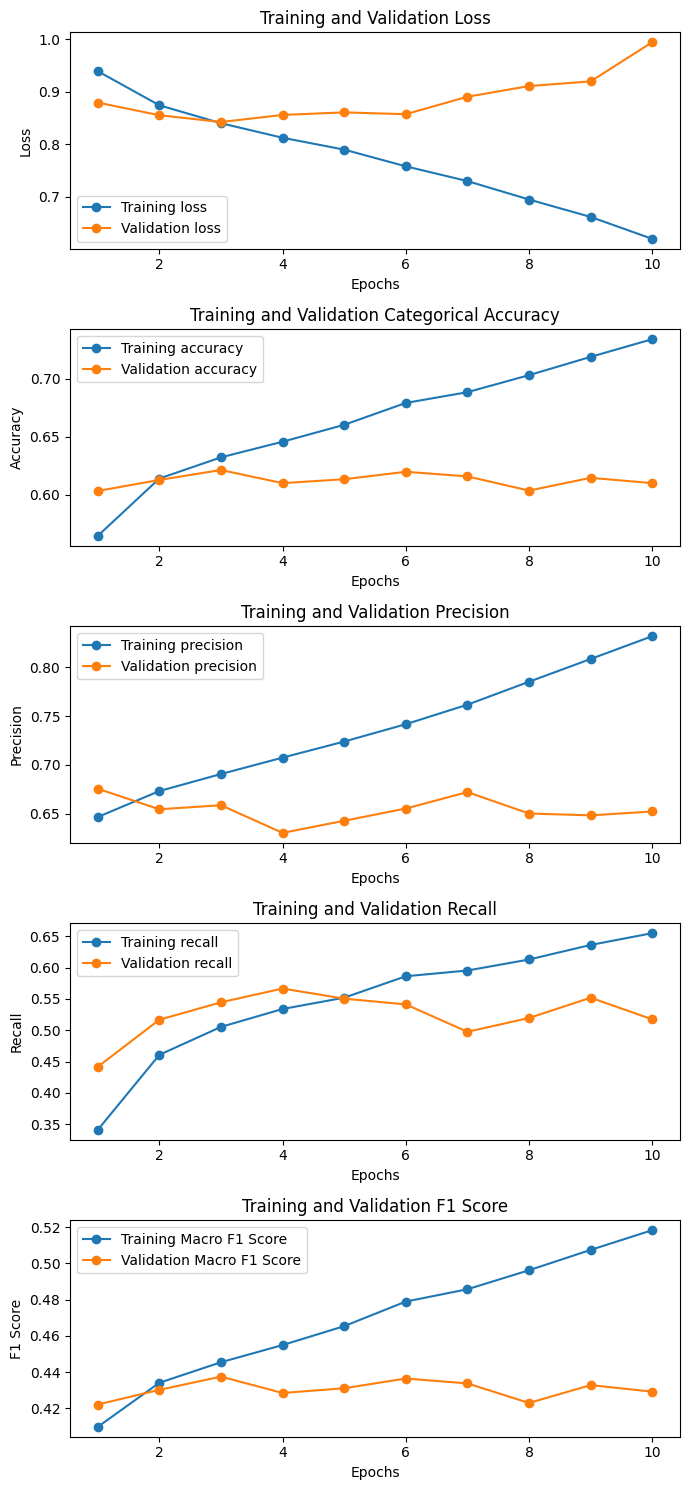

In [52]:
# Create subplots
fig, axes = plt.subplots(5, 1, figsize=(7, 15))
epochs = range(1, len(preq_roberta_hist.history['loss']) + 1)

axes[0].plot(epochs, preq_roberta_hist.history["loss"], 'o-', label='Training loss')
axes[0].plot(epochs, preq_roberta_hist.history["val_loss"], 'o-', label='Validation loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(epochs, preq_roberta_hist.history['categorical_accuracy'], 'o-', label='Training accuracy')
axes[1].plot(epochs, preq_roberta_hist.history['val_categorical_accuracy'], 'o-', label='Validation accuracy')
axes[1].set_title('Training and Validation Categorical Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

axes[2].plot(epochs, preq_roberta_hist.history["precision_4"], 'o-', label='Training precision')
axes[2].plot(epochs, preq_roberta_hist.history["val_precision_4"], 'o-', label='Validation precision')
axes[2].set_title('Training and Validation Precision')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Precision')
axes[2].legend()

axes[3].plot(epochs, preq_roberta_hist.history["recall_4"], 'o-', label='Training recall')
axes[3].plot(epochs, preq_roberta_hist.history["val_recall_4"], 'o-', label='Validation recall')
axes[3].set_title('Training and Validation Recall')
axes[3].set_xlabel('Epochs')
axes[3].set_ylabel('Recall')
axes[3].legend()

axes[4].plot(epochs, preq_roberta_hist.history["f1_score"], 'o-', label='Training Macro F1 Score')
axes[4].plot(epochs, preq_roberta_hist.history["val_f1_score"], 'o-', label='Validation Macro F1 Score')
axes[4].set_title('Training and Validation F1 Score')
axes[4].set_xlabel('Epochs')
axes[4].set_ylabel('F1 Score')
axes[4].legend()

plt.tight_layout()
plt.show()

In [29]:
preq_roberta_model.save('prequential_roberta_dpr_avg.keras')

/home/sysung98/MIDS/W266-final-project/envs/lib/python3.11/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)
